# EDA

In [15]:
#Google Colab needs
import os
import sys
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pyplot import figure
import seaborn as sns
from nltk.corpus import stopwords
sns.set_palette("pastel")
pal = sns.color_palette()
stops = set(stopwords.words("english"))

figure(num=None, figsize=(20, 15), dpi=80, facecolor='w', edgecolor='k');

def isCollab():
    return os.environ.get('COLAB_GPU', None) != None

if isCollab():
    #Mounting GDrive disc
    from google.colab import drive
    drive.mount('/content/gdrive')
    path_to_storage = '/content/gdrive/My Drive/UCU-2019-final-project-storage'

    #Append path where custom modules stored. I put custom modules to GDrive disc
    path_to_modules = '/content/gdrive/My Drive/UCU-2019-final-project-storage'
    sys.path.append(path_to_modules)
else:
    sys.path.append('..')
    path_to_storage = None

<Figure size 1600x1200 with 0 Axes>

In [2]:
import numpy as np
import pickle
import pandas as pd
import sys
sys.path.append('..')
from joblib import dump, load
if not path_to_storage:
    path_to_storage = os.path.abspath(os.path.join(os.getcwd(), '../storage')) 

data_folder = path_to_storage+'/data/'
serialization_objects_folder = path_to_storage+'/serialization_objects/'

In [3]:
if not path_to_storage:
    path_to_storage = os.path.abspath(os.path.join(os.getcwd(), '../storage')) 

In [4]:
data_folder = path_to_storage+'/data/'
serialization_objects_folder = path_to_storage+'/serialization_objects/'

In [5]:
dtypes = {
    'id': 'int64',
    'qid1': 'int64',
    'qid2': 'int64',
    'question1': 'object',
    'question2': 'object',
    'is_duplicate': 'int64'
}
df_train = pd.read_csv(data_folder+'train.csv',
                 header=0, 
                 usecols=dtypes.keys(), 
                 skipinitialspace=True,
                 skip_blank_lines=True,
                 encoding='utf-8')

df_train = df_train.set_index('id')
df_train = df_train.dropna()

In [6]:
df_train.head()

,qid1,qid2,question1,question2,is_duplicate
id,,,,,
0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


## Train set

In [7]:
print('Total number of question pairs for training: {}'.format(len(df_train)))
print('Duplicate pairs: {}%'.format(round(df_train['is_duplicate'].mean()*100, 2)))
qids = pd.Series(df_train['qid1'].tolist() + df_train['qid2'].tolist())
print('Total number of questions in the training data: {}'.format(len(
    np.unique(qids))))
print('Number of questions that appear multiple times: {}'.format(np.sum(qids.value_counts() > 1)))

Total number of question pairs for training: 404287
Duplicate pairs: 36.92%
Total number of questions in the training data: 537929
Number of questions that appear multiple times: 111778


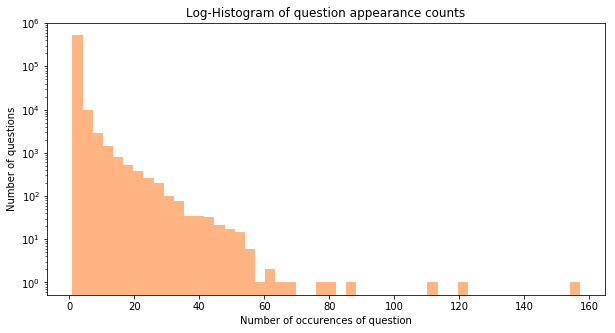

In [8]:
plt.figure(figsize=(10,5))
plt.hist(qids.value_counts(), bins=50)
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of questions')
print()
plt.hist(qids.value_counts(), bins=50, log=True);

Most questions arise only a few times, with several questions appearing several times (and several questions appearing many times). The question seems more than 160 times, but this is a release.

## Test set

In [9]:
dtypes = {
    'test_id': 'int64',
    'question1': 'object',
    'question2': 'object'
}
df_test = pd.read_csv(data_folder+'test.csv',
                 header=0, 
                 usecols=dtypes.keys(), 
                 skipinitialspace=True,
                 skip_blank_lines=True,
                 encoding='utf-8')

df_test = df_test.set_index('test_id')
df_test = df_test.dropna()

## Text analysis

#### Count characters in questions

/Users/denisporplenko/anaconda3/envs/ucu-2019-ml-final-project/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


mean-train 59.82 std-train 31.96 mean-test 60.07 std-test 31.62 max-train 1169.00 max-test 1176.00


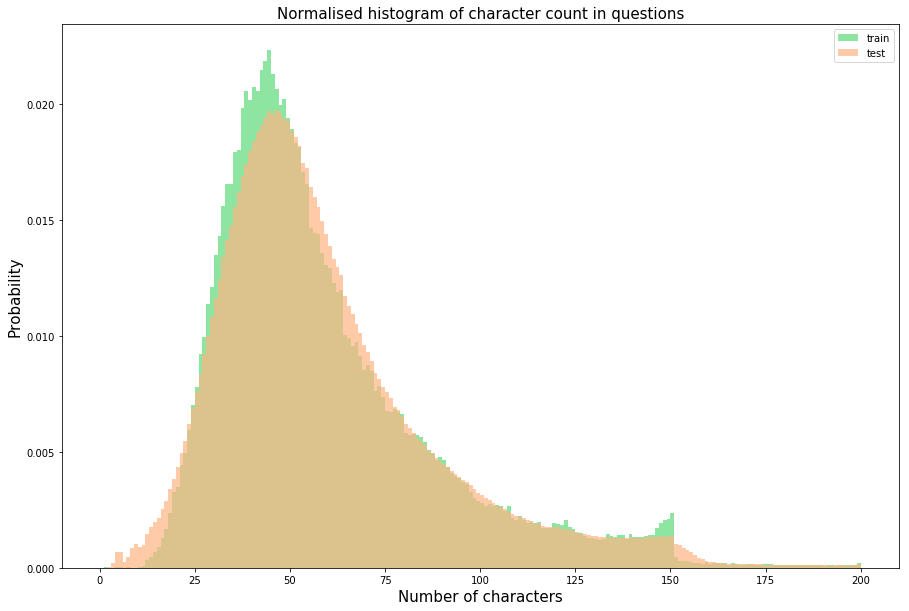

In [12]:
train_qs = pd.Series(df_train['question1'].tolist() + df_train['question2'].tolist()).astype(str)
test_qs = pd.Series(df_test['question1'].tolist() + df_test['question2'].tolist()).astype(str)

dist_train = train_qs.apply(len)
dist_test = test_qs.apply(len)
plt.figure(figsize=(15, 10))
plt.hist(dist_train, bins=200, range=[0, 200], color=pal[2], normed=True, label='train')
plt.hist(dist_test, bins=200, range=[0, 200], color=pal[1], normed=True, alpha=0.7, label='test')
plt.title('Normalised histogram of character count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of characters', fontsize=15)
plt.ylabel('Probability', fontsize=15)

print('mean-train {:.2f} std-train {:.2f} mean-test {:.2f} std-test {:.2f} max-train {:.2f} max-test {:.2f}'.format(dist_train.mean(), 
                          dist_train.std(), dist_test.mean(), dist_test.std(), dist_train.max(), dist_test.max()))

On this plot, we can see that more questions have from 20 to 150 characters. Distribution of test and train datasets are slightly different. We can see, cut-off at 150 characters for the training set (maybe it limited from Quora).   

#### Count words in questions

mean-train 11.06 std-train 5.89 mean-test 11.02 std-test 5.84 max-train 237.00 max-test 238.00


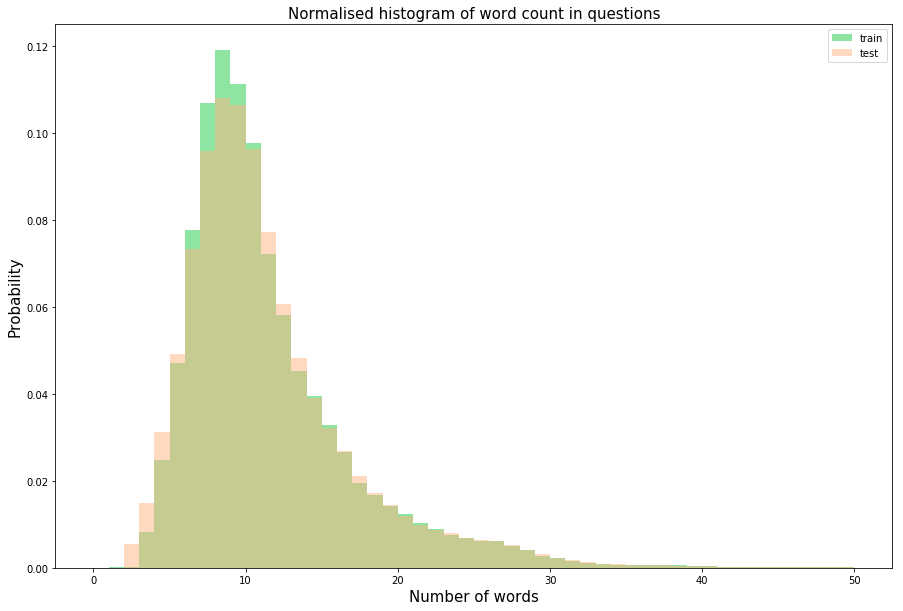

In [13]:
dist_train = train_qs.apply(lambda x: len(x.split(' ')))
dist_test = test_qs.apply(lambda x: len(x.split(' ')))

plt.figure(figsize=(15, 10))
plt.hist(dist_train, bins=50, range=[0, 50], color=pal[2], normed=True, label='train')
plt.hist(dist_test, bins=50, range=[0, 50], color=pal[1], normed=True, alpha=0.5, label='test')
plt.title('Normalised histogram of word count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Probability', fontsize=15)

print('mean-train {:.2f} std-train {:.2f} mean-test {:.2f} std-test {:.2f} max-train {:.2f} max-test {:.2f}'.format(dist_train.mean(), 
                          dist_train.std(), dist_test.mean(), dist_test.std(), dist_train.max(), dist_test.max()))

We can see, test and train count words distribution as the same.

#### Words Cloud

(-0.5, 1439.5, 1079.5, -0.5)

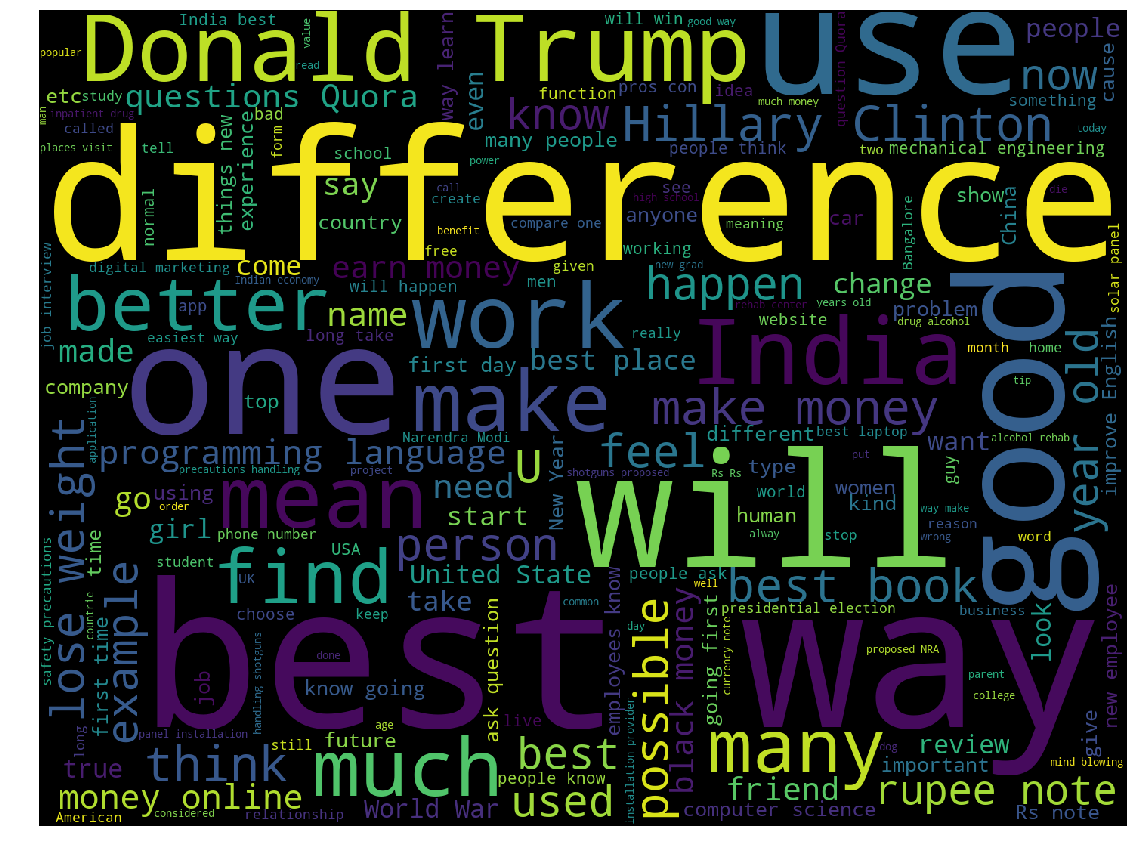

In [14]:
from wordcloud import WordCloud
cloud = WordCloud(width=1440, height=1080).generate(" ".join(train_qs.astype(str)))
plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.axis('off')

## Initial Feature Analysis

#### Feature: Share words

/Users/denisporplenko/anaconda3/envs/ucu-2019-ml-final-project/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Text(0.5, 0, 'word_match_share')

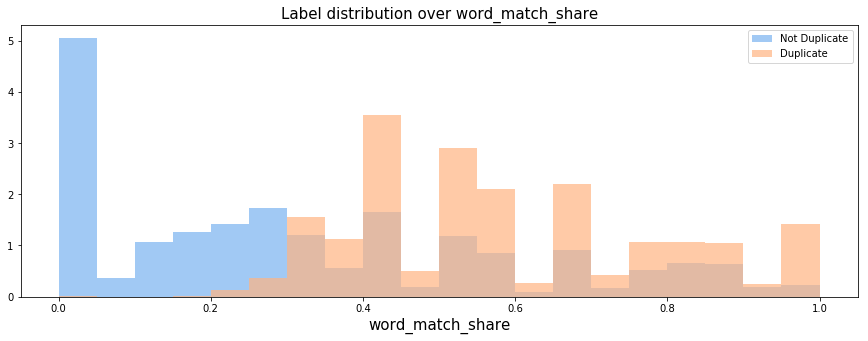

In [16]:
def word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    shared_words_in_q1 = [w for w in q1words.keys() if w in q2words]
    shared_words_in_q2 = [w for w in q2words.keys() if w in q1words]
    R = (len(shared_words_in_q1) + len(shared_words_in_q2))/(len(q1words) + len(q2words))
    return R

plt.figure(figsize=(15, 5))
train_word_match = df_train.apply(word_match_share, axis=1, raw=True)
plt.hist(train_word_match[df_train['is_duplicate'] == 0], bins=20, normed=True, label='Not Duplicate')
plt.hist(train_word_match[df_train['is_duplicate'] == 1], bins=20, normed=True, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution over word_match_share', fontsize=15)
plt.xlabel('word_match_share', fontsize=15)

We can see that the number of share words has good predictive power. Non-duplicate questions have fewer share words than duplicate questions